# Problems Disclaimer
The text itself mandates that no part of the book be reproduced without the publisher's explicit consent. As such, this notebook will not quote problems. Instead abreviated notes regarding the problems will be included with their solutions.

# Problem 1
In this problem, we'll focus on designing the first-half of a Kalman Filter by modeling a 1D dynamic system.

![Dynamic System](images/P1_system.png)

Since it's a simple system, we'll assume linear dynamics, thus position is represented by $x$, velocity by $\dot{x}$, and acceleration by $\ddot{x}$. Initially, all three of these parameters are set to zero, however *acceleration* in the system is noisy. Particularly, acceleration seems to be Gaussian distributed such that $\ddot{x} \sim \mathcal{N}(0,1)$. For this exercise, we'll assume that time is monotonically increasing, thus $\Delta t = 1$.

In this case, we can define a minimal state vector $x$ as follows:
$$
x = \begin{bmatrix} x \\ \dot{x} \\ \ddot{x} \end{bmatrix}
$$

To determine the state-transition probability distribution, we need to model the system state transition ($A$), the control state transition ($B$), and the system covariance ($R$).

Since it is a linear system, we need to limit how each state transitions to a strictly linear transform. Thus, changes in position are accumulative based upon the current velocity; changes in velocity are accumulative based upon the current acceleration; and we'll hold that acceleration does not change (normally, since we can treat it's noisy nature as strictly system noise). So our state-transition matrix results in:

$$
A_x = \begin{bmatrix} 1 & \Delta t & 0 \\ 0 & 1 & \Delta t \\ 0 & 0 & 0 \end{bmatrix} \text{ where } \Delta t = 1
$$

There is no control applied to the system, thus all $u_t = 0$, so we can assume that $B$ can be ignored.

As noted before, we're holding acceleration as constant in a noiseless system, so we know its true model is: $\ddot{x}_{t+1} = 0 + \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0,1)$.

It seems natural to extend $\sigma_\ddot{x}^2 = \sigma_\epsilon^2$ to a state-covariance $R_x$ as:
$$
R_x = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & \sigma_\epsilon^2 \end{bmatrix} \text{ where } \sigma_\epsilon^2 = 1
$$

But this results in a singular matrix. Let's instead take a look at our model and experimentally derive the covariance.

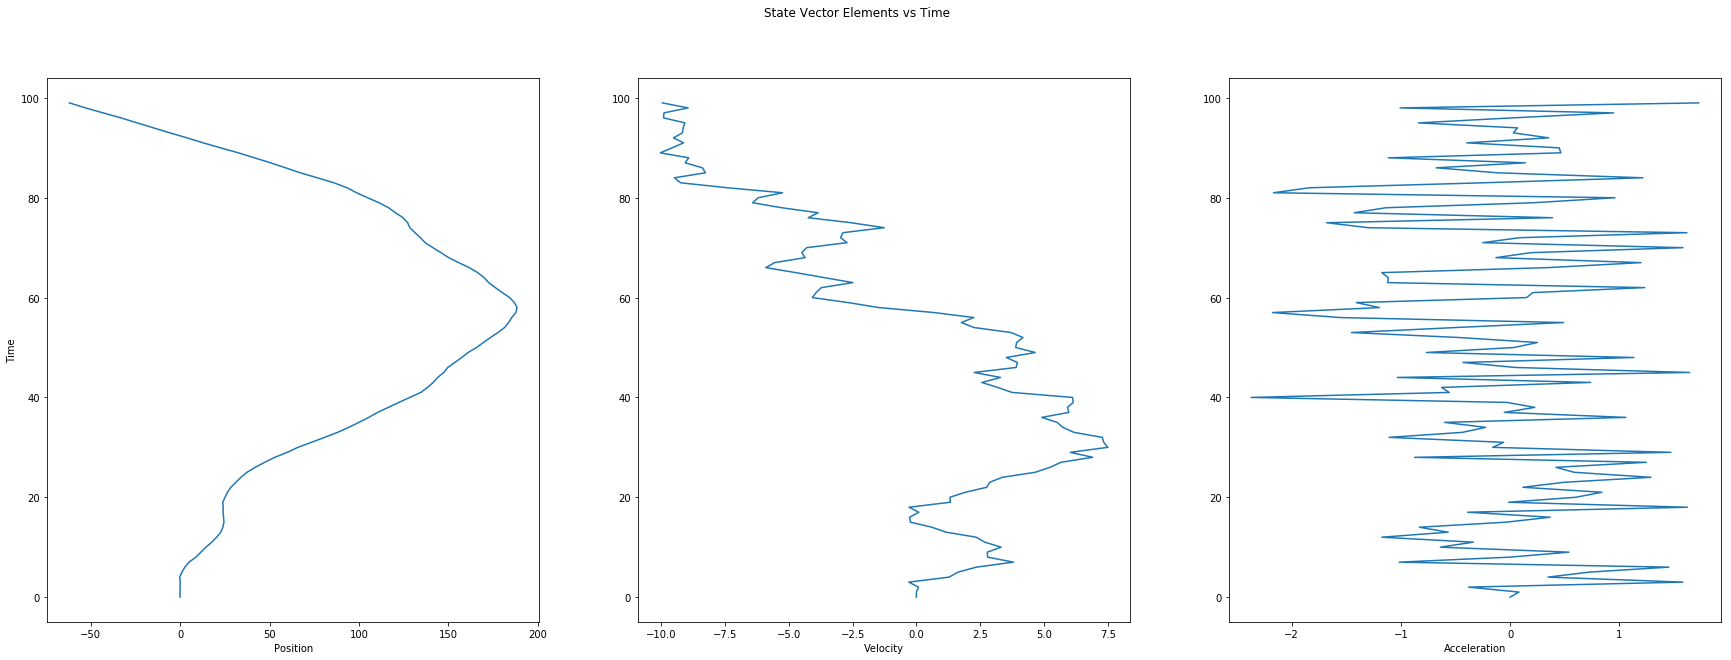

In [1]:
import numpy as np
from numpy.random import normal as normRV
from matplotlib import pyplot as plt
%matplotlib inline

def simulateModel(histLen=10):
    dt      = 1
    x_t     = np.zeros((3, histLen))
    A_x     = np.array([[1, dt,  0],
                        [0,  1, dt],
                        [0,  0,  0]])

    for tIdx in range(histLen - 1):
        x = x_t[:, tIdx]
        x1 = A_x.dot(x)
        x1[2] = normRV(0.0, 1.0)
        x_t[:, tIdx+1] = x1
    
    return x_t

def plotModel(x_t):
    histLen = x_t.shape[1]
    f = plt.figure(figsize=(30,10))
    f.suptitle("State Vector Elements vs Time")
    ax1 = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    ax1.plot(x_t[0,:],range(histLen))
    ax1.set_ylabel("Time")
    ax1.set_xlabel("Position")
    ax2.plot(x_t[1,:],range(histLen))
    ax2.set_xlabel("Velocity")
    ax3.plot(x_t[2,:],range(histLen))
    ax3.set_xlabel("Acceleration")

data1 = simulateModel(100)
plotModel(data1)

This stochastic process yields some interesting behaviors, mostly because of the accumulative nature of $x_t$ and $\dot{x}_t$. The acceleration state variable $\ddot{x}_t$ seems to be well centered about zero, but position and velocity are not. Of course, since this is a random process, what we observe experimentally will change with each subsequent experiment:

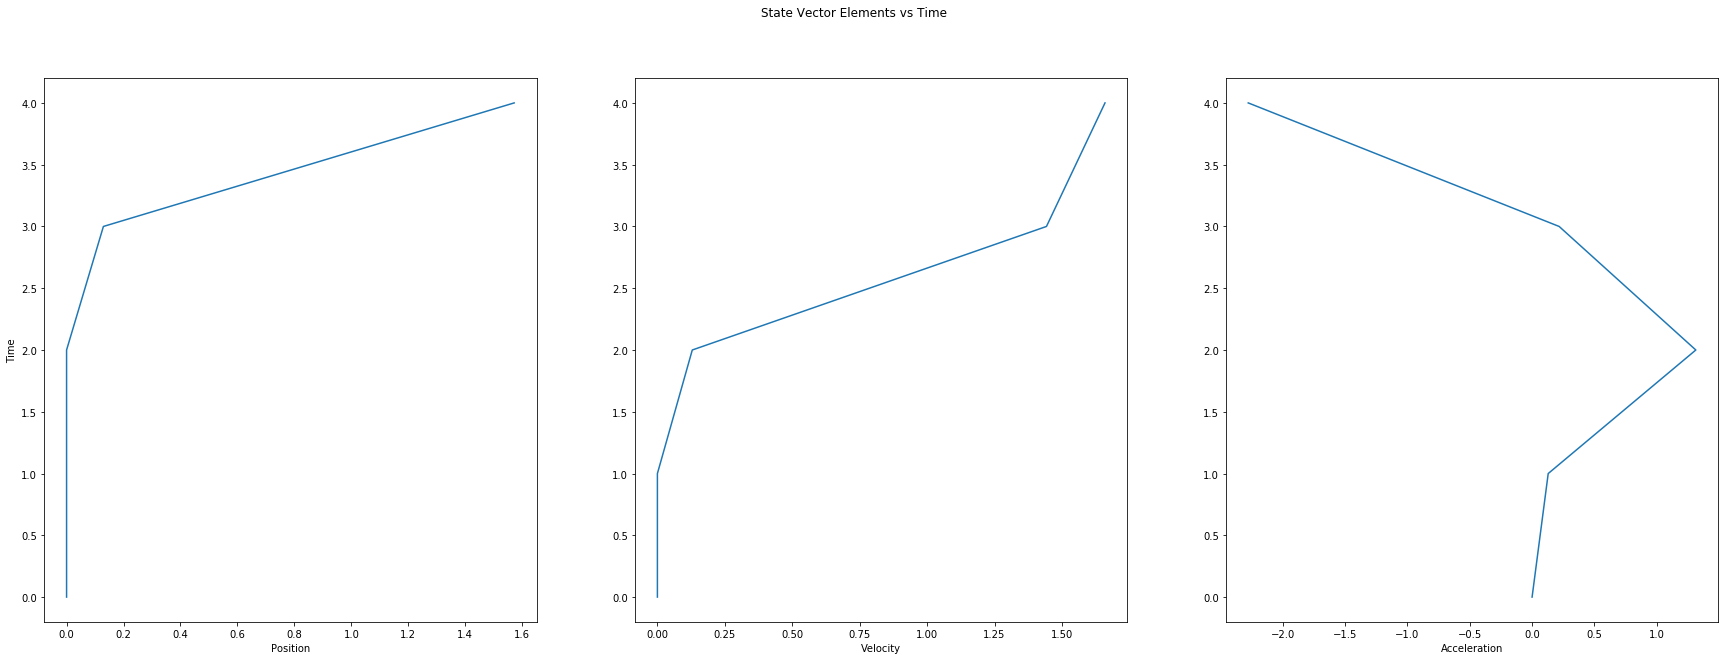

In [2]:
data2 = simulateModel(5)
plotModel(data2)

Overall, the modeling of position and velocity is a *[Random Walk](https://en.wikipedia.org/wiki/Stochastic_process#Random_walk)* in one dimension. Because of this, there is no real closed-form solution to derive the covariance. **This is often the case with real physical phenomena** and so we shouldn't shy away from computing the covariance from available data.

In [3]:
R1   = np.cov(data1)
R2   = np.cov(data2)
print("R1 = ")
print(R1)
print("R2 = ")
print(R2)

R1 = 
[[ 4.77563904e+03  7.18576776e+01 -1.56337623e+01]
 [ 7.18576776e+01  2.80806102e+01 -1.64920323e-01]
 [-1.56337623e+01 -1.64920323e-01  8.87724990e-01]]
R2 = 
[[ 0.47720161  0.42395449 -0.83521646]
 [ 0.42395449  0.69089744 -0.72420446]
 [-0.83521646 -0.72420446  1.72402722]]


Thusly we can now compute the state-transition probability:

$$
p(x_t | u_t, x_{t-1}) = p(x_t | x_{t-1}) = \\
\frac{1}{\sqrt{2\pi \det(R_x)}} \exp \left( -\frac{1}{2} (x_t - A_x x_{t-1})^\top R_x^{-1} (x_t - A_x x_{t-1}) \right) \\
$$

Let's just look at the prediction portion of a Kalman filter by assuming perfect correction (this way we're not dependent upon sensor data); we'll do this for only five time-steps.

In [4]:
R = R2 # Set up tuning
def kalmanPredict(mu0, Sigma0):
    A_x     = np.array([[1, 1, 0],
                        [0, 1, 1],
                        [0, 0, 0]])
    mu1 = A_x.dot(mu0)
    Sigma1 = (A_x.dot(Sigma0)).dot(A_x.T) + R
    return (mu1, Sigma1)

mu_series = np.zeros((3,5))
Sigma_series = np.zeros((3,3,5))
Sigma_series[:,:,0] = R2 # set up initial condition

for t in range(4):
    m0 = data2[:,t]
    S0 = Sigma_series[:,:,t]
    
    m1,S1 = kalmanPredict(m0,S0)
    mu_series[:,t+1] = m1
    Sigma_series[:,:,t+1] = S1

Let's take a look and see if we can find some correlation between position and velocity:

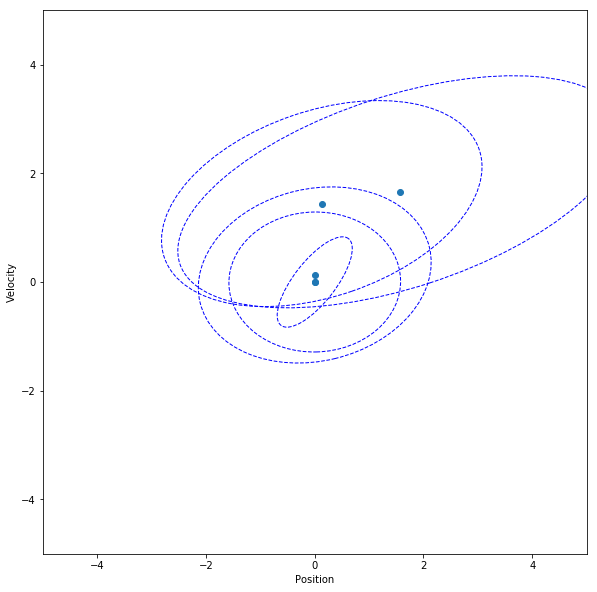

In [5]:
from matplotlib.patches import Ellipse

def plotAOU(mu_series, cov_series):
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111, aspect='equal')
    ax.set_xlim([-5.0, 5.0])
    ax.set_ylim([-5.0, 5.0])
    sLen = mu_series.shape[1]
    for t in range(sLen):
        mu = mu_series[0:2, t]
        cov = cov_series[0:2,0:2,t]
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        eW = lambda_[0]*2
        eH = lambda_[1]*2
        eA = np.rad2deg(np.arccos(v[0, 0]))
        
        el = Ellipse(xy=mu, width=eW, height=eH, angle=eA)
        el.set_facecolor('none')
        el.set_edgecolor('b')
        el.set_linestyle('dashed')
        ax.add_artist(el)
    pv_scat = mu_series[0:2, :]
    plt.scatter(pv_scat[0,:], pv_scat[1,:])
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')

plotAOU(mu_series, Sigma_series)

There are two things we can notice from this plot. Firstly, the covariance estimate is *growing* with time; this makes sense since we cannot correct the estimates with measurements (yet), so the uncertainty will simply compound. Second, the angle of the axes uncertainty ellipse is moving away from the cross-angles (45/225 or 135/315) and towards the cardinal angles -- this signifies a loss of correllation (that is, that position and velocity are orthogonal dimensions with one another). This also makes sense because of the lagging-update with velocity and position.